# 基于 DBSCAN 的地震点聚类模型（Loma Prieta Aftershocks）

## 知识点
- DBSCAN 是基于密度的聚类算法；
- 无需预先指定聚类数，通过 eps 与 min_samples 控制“密度”；
- 能发现任意形状的簇，并将离群点标记为噪声（标签 -1）。

## 实验目的
1) 建立 DBSCAN 模型对地震点进行聚类；
2) 绘制散点并叠加地图底图进行可视化。

## 实验步骤概览
1) 读取数据并查看前 5 行；
2) 数据描述与缺失值检查；
3) 地图散点可视化（Basemap/回退方案）；
4) DBSCAN 聚类与结果可视化；
5) 总结结论。

In [1]:
# Code 001/002: 读取数据与预览
import pandas as pd

df = pd.read_csv('LomaPrieta_aftershocks_1week_above_2.csv', skiprows=7)
print('Shape:', df.shape)
df.head()

Shape: (1009, 12)


,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,1989/10/18 00:04:15.19,37.0362,-121.8798,17.21,7.0,ML,80.0,89.0,1.0,0.08,NC,216859.0
1,1989/10/18 00:07:15.29,37.2382,-121.9445,9.37,4.7,ML,8.0,81.0,16.0,0.16,NC,10090521.0
2,1989/10/18 00:07:43.30,36.9880,-121.7413,15.26,4.7,ML,12.0,121.0,8.0,0.06,NC,10090522.0
3,1989/10/18 00:08:21.99,37.0702,-121.8940,10.43,4.4,ML,11.0,133.0,7.0,0.16,NC,10090523.0
4,1989/10/18 00:08:45.47,37.0760,-121.9250,2.96,4.3,ML,6.0,248.0,14.0,0.03,NC,10090509.0


In [2]:
# Code 003/004: 描述与缺失值
print('Describe:')
display(df.describe())

print('\nMissing values per column:')
display(df.isnull().sum())

Describe:


,Latitude,Longitude,Depth,Magnitude,NbStations,Gap,Distance,RMS,EventID
count,1009.000000,1009.000000,1009.000000,1009.000000,1008.000000,727.00000,727.000000,1008.000000,9.610000e+02
mean,34.024393,-92.731139,19.059415,2.914232,34.296627,86.92022,5.797799,0.282153,4.347089e+10
std,14.204189,75.037975,48.760058,0.887895,27.978647,51.64057,9.005300,0.404667,8.223878e+10
min,-57.333000,-179.884000,-1.320000,2.000000,3.000000,24.00000,0.000000,0.000000,4.660000e+02
25%,36.939700,-121.972700,5.840000,2.260000,15.000000,56.00000,2.000000,0.070000,2.597680e+05
50%,37.073300,-121.812000,10.000000,2.590000,28.000000,71.00000,4.000000,0.090000,1.009044e+07
75%,37.175500,-120.430000,13.460000,3.250000,47.000000,97.00000,6.000000,0.210000,2.009186e+07
max,66.875500,179.809000,649.200000,7.000000,287.000000,354.00000,102.000000,1.820000,1.989102e+11



Missing values per column:


DateTime        0
Latitude        0
Longitude       0
Depth           0
Magnitude       0
MagType         0
NbStations      1
Gap           282
Distance      282
RMS             1
Source          0
EventID        48
dtype: int64

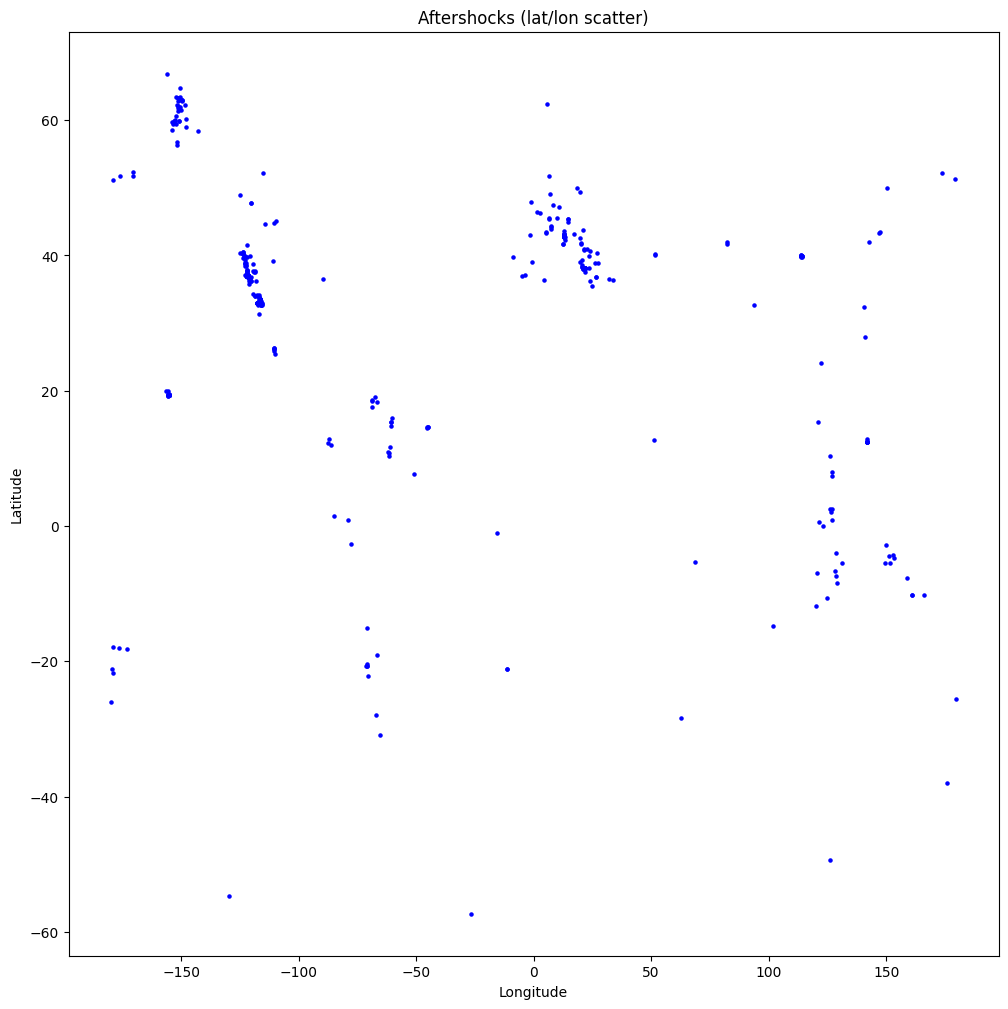

In [3]:
# Code 005: 地图底图叠加散点（Basemap 可用则使用，否则回退简单散点）
import matplotlib.pyplot as plt

# 尝试构造坐标数组
if {'Latitude', 'Longitude'}.issubset(df.columns):
    coords = df[['Latitude', 'Longitude']].to_numpy()
else:
    # 兼容大小写差异
    lat_col = [c for c in df.columns if c.lower() == 'latitude'][0]
    lon_col = [c for c in df.columns if c.lower() == 'longitude'][0]
    coords = df[[lat_col, lon_col]].to_numpy()

plt.figure(figsize=(12, 12))
try:
    from mpl_toolkits.basemap import Basemap
    m = Basemap(projection='merc', resolution='l', epsg=4269,
                llcrnrlon=-122.7, llcrnrlat=36.2, urcrnrlon=-120.8, urcrnrlat=37.5)
    x, y = m(coords[:, 1], coords[:, 0])
    m.scatter(x, y, 5, marker='o', color='b', zorder=10)
    try:
        m.arcgisimage(service='World_Shaded_Relief', xpixels=2000, verbose=False)
    except Exception:
        pass
    plt.title('Aftershocks (with Basemap)')
except Exception:
    # 回退方案：直接以经纬度为坐标散点
    plt.scatter(coords[:, 1], coords[:, 0], s=5, c='b')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Aftershocks (lat/lon scatter)')

plt.show()

In [4]:
# Code 006: 基于 DBSCAN 的聚类
from sklearn.cluster import DBSCAN
import numpy as np

kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian  # 约 1.5 公里

# 使用哈弗辛距离，需要将坐标转换为弧度
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(coords))

cluster_labels = db.labels_
print('Cluster labels (first 50):', cluster_labels[:50])

# 统计聚类数量（含噪声标签 -1）
unique_labels = np.unique(cluster_labels)
n_clusters = len(unique_labels[unique_labels != -1])
print('Number of clusters (excluding noise):', n_clusters)

# 将每个簇的坐标收集到列表中（包含噪声 -1）
clusters = [coords[cluster_labels == n] for n in unique_labels]

Cluster labels (first 50): [-1 -1  0  1  1  2  0  2  2  2  0  2  2  2  1  2  2 -1 -1  2  2  1  1  0
  0  0  3  0  1  0  2  2  2  2  2  3  1  0  1  2  2  2  3  2  1  0  1  4
  2  4]
Number of clusters (excluding noise): 9


In [5]:
# Code 007: 自定义着色函数
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    color_norm = colors.Normalize(vmin=0, vmax=max(N - 1, 1))
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='nipy_spectral')

    def map_index_to_rgba(index):
        return scalar_map.to_rgba(index)

    return map_index_to_rgba

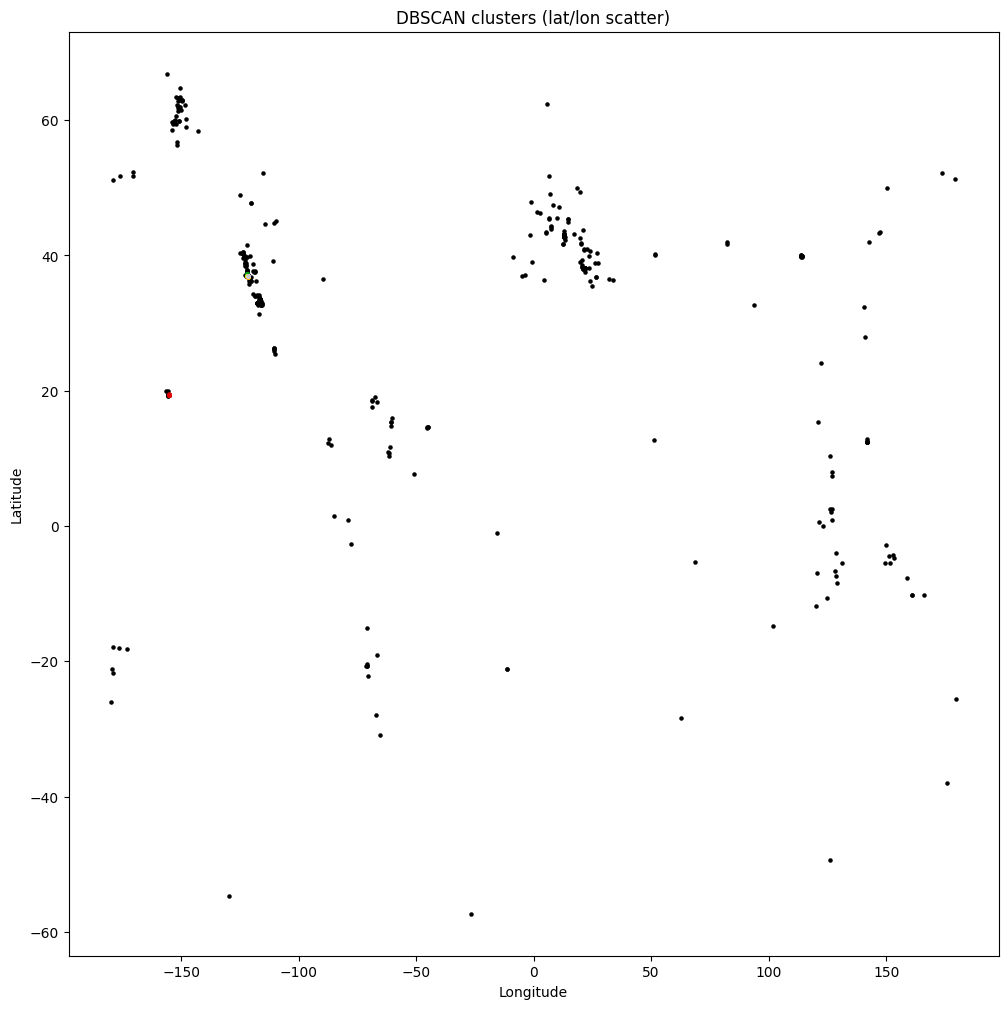

In [6]:
# Code 008: 聚类结果可视化（叠加底图，失败则回退）
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
try:
    from mpl_toolkits.basemap import Basemap
    m = Basemap(projection='merc', resolution='l', epsg=4269,
                llcrnrlon=-122.7, llcrnrlat=36.2, urcrnrlon=-120.8, urcrnrlat=37.5)
    unique_label = np.unique(cluster_labels)
    cmaps = get_cmap(len(unique_label))

    for i, label in enumerate(unique_label):
        cluster = coords[cluster_labels == label]
        if cluster.size == 0:
            continue
        lons_select = cluster[:, 1]
        lats_select = cluster[:, 0]
        x, y = m(lons_select, lats_select)
        color = 'k' if label == -1 else cmaps(i)
        m.scatter(x, y, 5, marker='o', color=color, zorder=10)
    try:
        m.arcgisimage(service='World_Shaded_Relief', xpixels=2000, verbose=False)
    except Exception:
        pass
    plt.title('DBSCAN clusters (with Basemap)')
except Exception:
    unique_label = np.unique(cluster_labels)
    cmaps = get_cmap(len(unique_label))
    for i, label in enumerate(unique_label):
        cluster = coords[cluster_labels == label]
        if cluster.size == 0:
            continue
        color = 'k' if label == -1 else cmaps(i)
        plt.scatter(cluster[:, 1], cluster[:, 0], s=5, c=[color])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('DBSCAN clusters (lat/lon scatter)')

plt.show()

## 实验结论

- DBSCAN 基于密度聚类，无需预设簇数，并自动标记噪声点（-1）；
- 相较 kmeans，DBSCAN 更擅长发现非球状、非线性的簇结构；
- eps 与 min_samples 的选择会显著影响结果，建议结合领域知识与可视化调参。